In [33]:
import numpy as np
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
from astropy import units as u
from astropy.constants import M_earth, M_sun

### Let's start by modeling what Earth's astrometry + RV signal could look like....

Earth Parameters:
(https://nssdc.gsfc.nasa.gov/planetary/factsheet/earthfact.html)


Period = 365.256

Eccentricity = 0.0167

Semi-Amplitude = 0.0902 m/s.... (https://www.wolframalpha.com/input/?i=%5B%282*pi*gravitational+constant%29%2F+%28365.256+days%29%5D%5E%281%2F3%29+*+%28m_earth%2Fm_sun%5E%282%2F3%29%29*%281%2F%28sqrt%281-0.0167%29%29%29)

K_earth = [(2*pi*gravitational constant)/ (365.256 days)]^(1/3) * (m_earth/m_sun^(2/3))*(1/(sqrt(1-0.0167)))

Time of midtransit = 2459223.2406944 BJD (Jan 8, 2021 at 12:46)

small omega (argument of periapsis) = 288.1 deg (https://en.wikipedia.org/wiki/Earth%27s_orbit)

big omega (longitude of ascending node) = 174.9 deg (https://en.wikipedia.org/wiki/Earth%27s_orbit)


inclination = 70 deg (just assume this)

semi-major axis = 149.596 *10^6 km

semi-major axis (at 10 pc) = 4.848×10^-7 as = 0.4848 micro-as


In [34]:
P_earth = 365.256
e_earth = 0.0167
T0_earth= 2459223.2406944
omega_earth = np.radians(288.1)
Omega_earth = np.radians(174.9)
inclination_earth = np.radians(70)
m_earth = 1 #units m_earth

### We will use the class exoplanet.orbits.KeplerianOrbit to simulate the RV and astrometry data

#### parameters:

- period – The orbital periods of the bodies in days.

- a – The semimajor axes of the orbits in R_sun.

- t0 – The time of a reference transit for each orbits in days.

- t_periastron – The epoch of a reference periastron passage in days.

- incl – The inclinations of the orbits in radians.

- b – The impact parameters of the orbits.

- ecc – The eccentricities of the orbits. Must be 0 <= ecc < 1.

- omega – The arguments of periastron for the orbits in radians.

- Omega – The position angles of the ascending nodes in radians.

- m_planet – The masses of the planets in units of m_planet_units.

- m_star – The mass of the star in M_sun.

- r_star – The radius of the star in R_sun.

- rho_star – The density of the star in units of rho_star_units.

- m_planet_units – An astropy.units compatible unit object giving the units of the planet masses. If not given, the default is M_sun.

- rho_star_units – An astropy.units compatible unit object giving the units of the stellar density. If not given, the default is g / cm^3.

#### -----------

A system of bodies on Keplerian orbits around a common central

Given the input parameters, the values of all other parameters will be computed so a KeplerianOrbit instance will always have attributes for each argument. Note that the units of the computed attributes will all be in the standard units of this class (R_sun, M_sun, and days) except for rho_star which will be in g / cm^3.

There are only specific combinations of input parameters that can be used:

- First, either period or a must be given. If values are given for both parameters, then neither m_star or rho_star can be defined because the stellar density implied by each planet will be computed in rho_star.

- Only one of incl and b can be given.

- If a value is given for ecc then omega must also be given.

- If no stellar parameters are given, the central body is assumed to be the sun. If only rho_star is defined, the radius of the central is assumed to be 1 * R_sun. Otherwise, at most two of m_star, r_star, and rho_star can be defined.

- Either t0 (reference transit) or t_periastron must be given, but not both.

In [35]:
orbit_earth = xo.orbits.KeplerianOrbit(
    period = P_earth, 
    ecc = e_earth, 
    t0 = T0_earth, 
    omega = omega_earth, 
    Omega = Omega_earth,  
    incl = inclination_earth,
    m_planet = m_earth, 
    m_planet_units = u.M_earth)


In [36]:
times = np.linspace(T0_earth, T0_earth+P_earth, 1000)
times_observed= np.linspace(T0_earth, T0_earth+P_earth, 365)
plx = 0.1 #assume distance = 10 pc

In [37]:
rv_earth = orbit_earth.get_radial_velocity(times)
rv_orbit_earth = rv_earth.eval()

rho_earth, theta_earth = orbit_earth.get_relative_angles(times, plx)
rho_orbit_earth = rho_earth.eval()
theta_orbit_earth = theta_earth.eval()

/Users/Danielyahalomi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
/Users/Danielyahalomi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


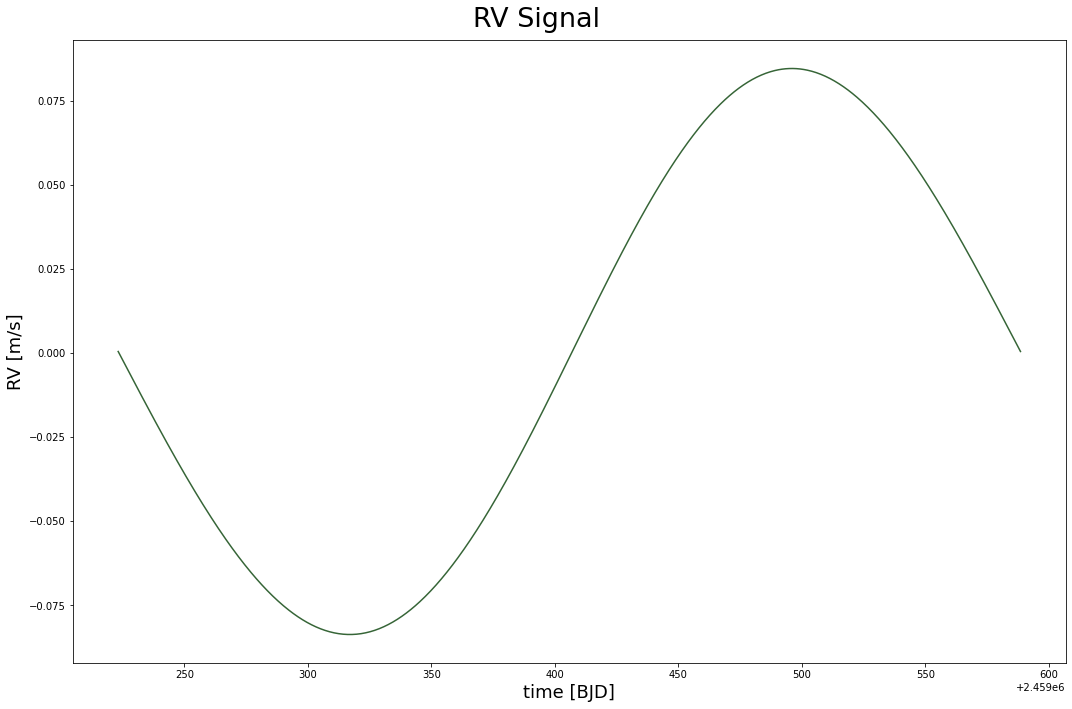

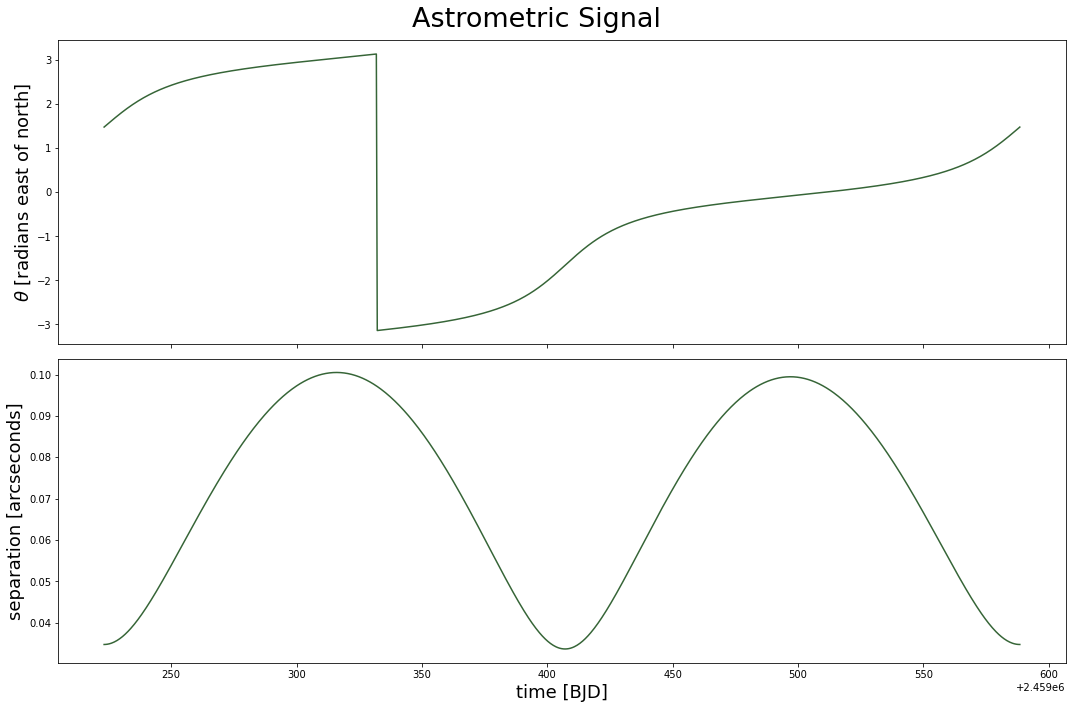

In [38]:
fig, ax = plt.subplots(1, figsize = [15,10])
fig.suptitle("RV Signal", fontsize = 27)

ax.plot(times, rv_orbit_earth, color = '#366537')
ax.set_xlabel("time [BJD]", fontsize = 18)
ax.set_ylabel("RV [m/s]", fontsize = 18)
fig.tight_layout()
fig.show()

#-----------
#-----------

fig, ax = plt.subplots(2, figsize = [15,10], sharex = True)
fig.suptitle("Astrometric Signal", fontsize = 27)
ax0 = ax[0]
ax1 = ax[1]

ax[0].plot(times, theta_orbit_earth, color = '#366537')
ax0.set_ylabel(r"$\theta$ [radians east of north]", fontsize = 18)

ax[1].plot(times, rho_orbit_earth, color = '#366537')
ax1.set_ylabel("separation [arcseconds]", fontsize = 18)
ax1.set_xlabel("time [BJD]", fontsize = 18)

fig.tight_layout()
fig.show()

### Ok great! Now, let's simulate what Jupiter's astrometry + RV signal could look like....



Period = 4,332.589

Eccentricity = 0.0489

Time of midtransit = 2457388.50069 BJD (Jan 1, 2016 at 01:00)

small omega (argument of periapsis) = 273.867 deg (https://en.wikipedia.org/wiki/Jupiter)

big omega (longitude of ascending node) = 100.464 deg (https://en.wikipedia.org/wiki/Jupiter)

inclination = 1.31deg + i_earth  (https://en.wikipedia.org/wiki/Jupiter)


In [39]:
P_jup = 4332.589
e_jup = 0.0489
T0_jup = 2457388.50069
omega_jup = np.radians(273.867)
Omega_jup = np.radians(100.464)
inclination_jup = np.radians(1.31) + inclination_earth
m_jup = 317.83 #units m_earth

In [40]:
orbit_jup = xo.orbits.KeplerianOrbit(
    period = P_jup, 
    ecc = e_jup, 
    t0 = T0_jup, 
    omega = omega_jup, 
    Omega = Omega_jup,  
    incl = inclination_jup,
    m_planet = m_jup, 
    m_planet_units = u.M_earth)

In [41]:
rv_jup = orbit_jup.get_radial_velocity(times)
rv_orbit_jup = rv_jup.eval()

rho_jup, theta_jup = orbit_jup.get_relative_angles(times, plx)
rho_orbit_jup = rho_jup.eval()
theta_orbit_jup = theta_jup.eval()

/Users/Danielyahalomi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
/Users/Danielyahalomi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


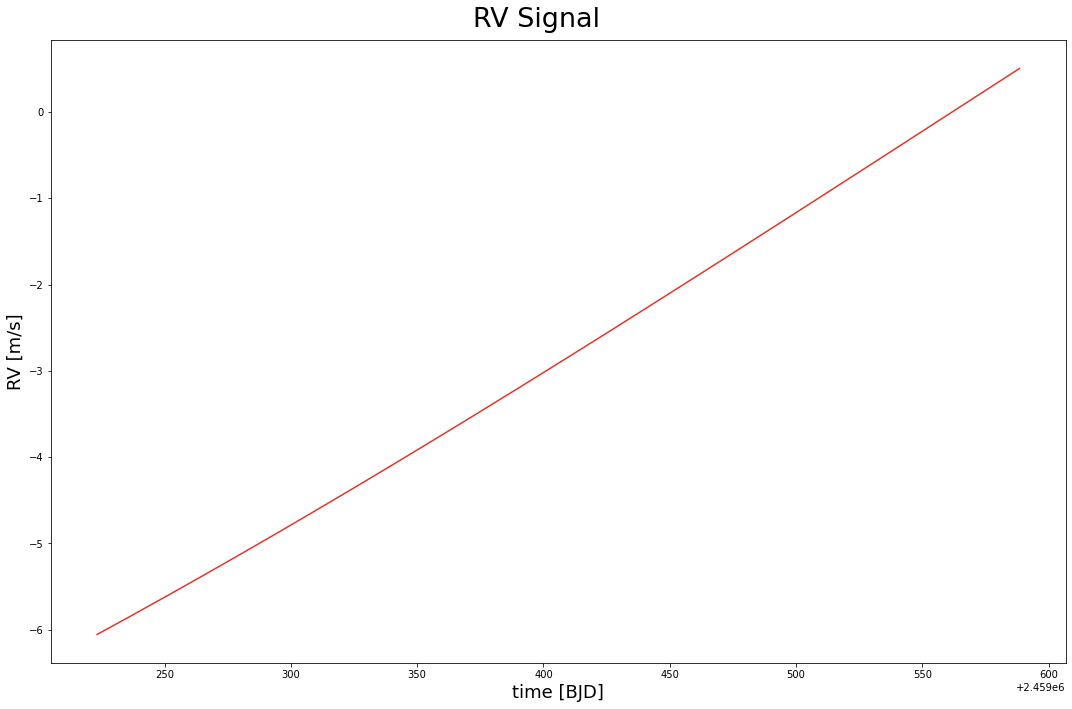

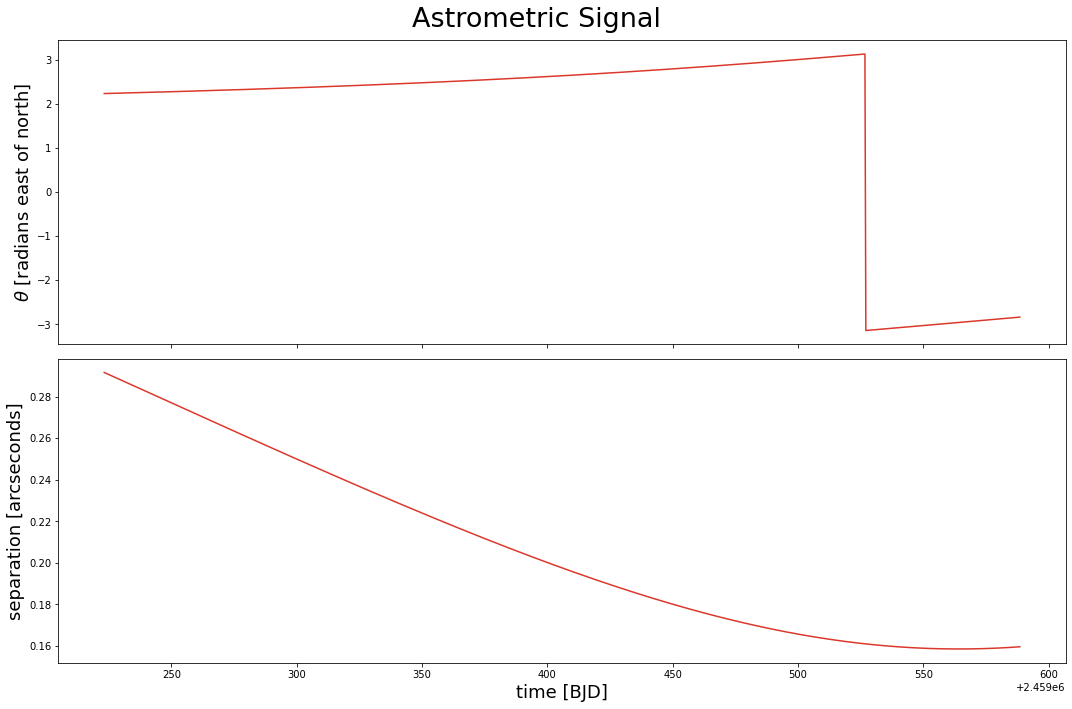

In [42]:
fig, ax = plt.subplots(1, figsize = [15,10])
fig.suptitle("RV Signal", fontsize = 27)

ax.plot(times, rv_orbit_jup, color = '#db372b')
ax.set_xlabel("time [BJD]", fontsize = 18)
ax.set_ylabel("RV [m/s]", fontsize = 18)
fig.tight_layout()
fig.show()

#-----------
#-----------

fig, ax = plt.subplots(2, figsize = [15,10], sharex = True)
fig.suptitle("Astrometric Signal", fontsize = 27)
ax0 = ax[0]
ax1 = ax[1]

ax[0].plot(times, theta_orbit_jup, color = '#db372b')
ax0.set_ylabel(r"$\theta$ [radians east of north]", fontsize = 18)

ax[1].plot(times, rho_orbit_jup, color = '#db372b')
ax1.set_ylabel("separation [arcseconds]", fontsize = 18)
ax1.set_xlabel("time [BJD]", fontsize = 18)

fig.tight_layout()
fig.show()

In [46]:
orbit_both = xo.orbits.KeplerianOrbit(
    period = [P_earth, P_jup],
    ecc = [e_earth, e_jup], 
    t0 = [T0_earth, T0_jup], 
    omega = [omega_earth, omega_jup], 
    Omega = [Omega_earth, Omega_jup],  
    incl = [inclination_earth, inclination_jup],
    m_planet = [m_earth, m_jup], 
    m_planet_units = u.M_earth)

In [47]:
rv_both = orbit_both.get_radial_velocity(times)
rv_both_observed = orbit_both.get_radial_velocity(times_observed)

rv_orbit_both = rv_both.eval()
rv_orbit_sum = rv_orbit_both.T[0]+rv_orbit_both.T[1]

rv_observed_both = rv_both_observed.eval()
rv_observed_sum = rv_observed_both.T[0]+rv_observed_both.T[1]


#-----------
#-----------

rho_both, theta_both = orbit_both.get_relative_angles(times, plx)

rho_orbit_both = rho_both.eval()
rho_orbit_sum = rho_orbit_both.T[0]+rho_orbit_both.T[1]

theta_orbit_both = theta_both.eval()
theta_orbit_sum = theta_orbit_both.T[0]+theta_orbit_both.T[1]





rho_both_observed, theta_both_observed = orbit_both.get_relative_angles(times_observed, plx)

rho_observed_both = rho_both_observed.eval()
rho_observed_sum = rho_observed_both.T[0]+rho_observed_both.T[1]

theta_observed_both = theta_both_observed.eval()
theta_observed_sum = theta_observed_both.T[0]+theta_observed_both.T[1]


#----------- 
#----------- 
#----------- simulate data
#----------- 
#----------- 

rv_sim_both = np.vstack((rv_observed_both.T[0] + np.random.normal(0,0.1,len(rv_observed_both)), rv_observed_both.T[1] + np.random.normal(0,0.1,len(rv_observed_both)))).T
rv_sim_sum = rv_observed_sum + np.random.normal(0,0.1,len(rv_observed_sum))


#-----------
#-----------


rho_sim_both = np.vstack((rho_observed_both.T[0] + np.random.normal(0,0.01,len(rho_observed_both)), rho_observed_both.T[1] + np.random.normal(0,0.01,len(rho_observed_both)))).T
rho_sim_sum = rho_observed_sum + np.random.normal(0,0.01,len(rho_observed_sum))

theta_sim_both = np.vstack((theta_observed_both.T[0] + np.random.normal(0,0.1,len(theta_observed_both)), theta_observed_both.T[1] + np.random.normal(0,0.1,len(theta_observed_both)))).T
theta_sim_sum = theta_observed_sum + np.random.normal(0,0.1,len(theta_observed_sum))

/Users/Danielyahalomi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/Danielyahalomi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


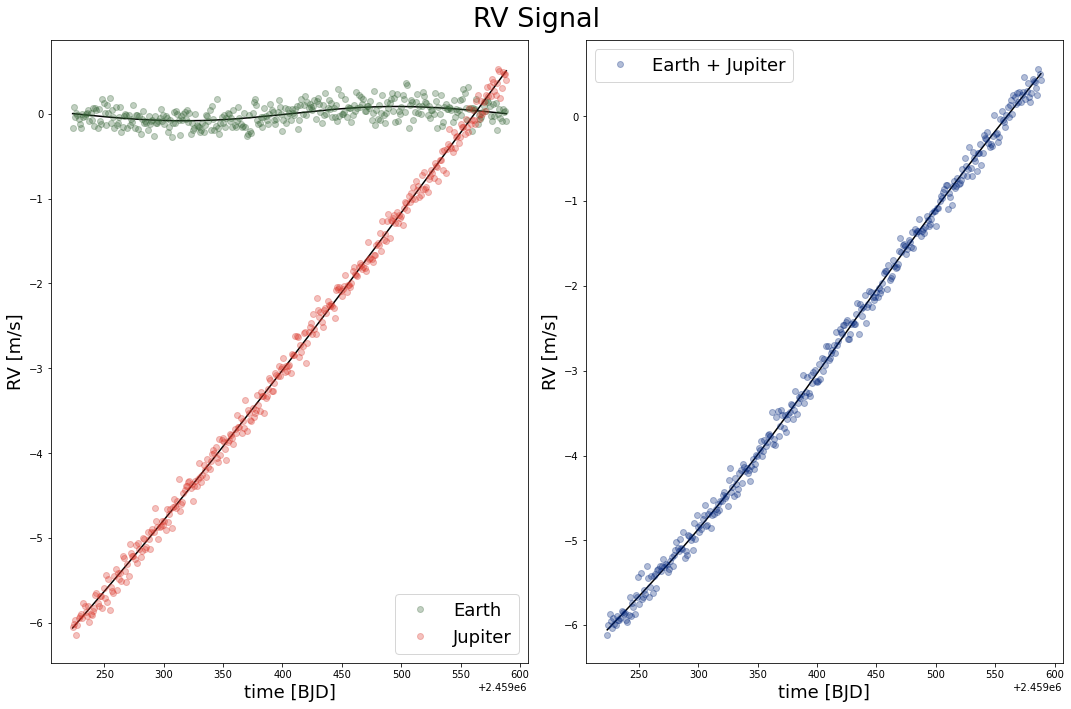

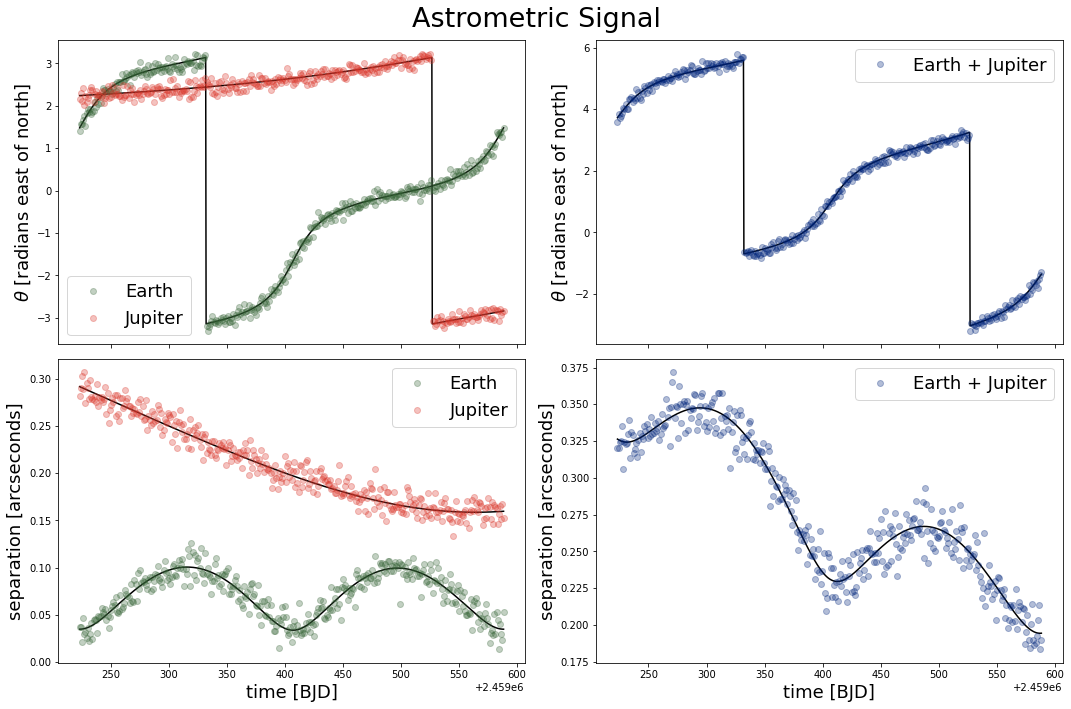

In [48]:
fig, ax = plt.subplots(1, 2, figsize = [15,10])
fig.suptitle("RV Signal", fontsize = 27)
ax0 = ax[0]
ax1 = ax[1]

ax0.plot(times, rv_orbit_both.T[0], color = 'k')
ax0.plot(times_observed, rv_sim_both.T[0], 'o', color = '#366537', label = 'Earth', alpha = 0.3)
ax0.plot(times, rv_orbit_both.T[1], color = 'k')
ax0.plot(times_observed, rv_sim_both.T[1], 'o', color = '#db372b', label = 'Jupiter', alpha = 0.3)
ax0.legend(fontsize = 18)

ax0.set_xlabel("time [BJD]", fontsize = 18)
ax0.set_ylabel("RV [m/s]", fontsize = 18)

ax1.plot(times, rv_orbit_sum, color = 'k')
ax1.plot(times_observed, rv_sim_sum, 'o', color = '#00257c', label = 'Earth + Jupiter', alpha = 0.3)

ax1.set_xlabel("time [BJD]", fontsize = 18)
ax1.set_ylabel("RV [m/s]", fontsize = 18)
ax1.legend(fontsize = 18)

fig.tight_layout()
fig.show()

#-----------
#-----------

fig, ax = plt.subplots(2, 2, figsize = [15,10], sharex = True)
fig.suptitle("Astrometric Signal", fontsize = 27)
ax0 = ax[0][0]
ax1 = ax[1][0]
ax2 = ax[0][1]
ax3 = ax[1][1]

ax0.plot(times, theta_orbit_both.T[0], color = 'k')
ax0.plot(times, theta_orbit_both.T[1], color = 'k')
ax0.plot(times_observed, theta_sim_both.T[0], 'o', color = '#366537', label = 'Earth', alpha = 0.3)
ax0.plot(times_observed, theta_sim_both.T[1], 'o', color = '#db372b', label = 'Jupiter', alpha = 0.3)
ax0.set_ylabel(r"$\theta$ [radians east of north]", fontsize = 18)
ax0.legend(fontsize = 18)

ax1.plot(times, rho_orbit_both.T[0], color = 'k')
ax1.plot(times, rho_orbit_both.T[1], color = 'k')
ax1.plot(times_observed, rho_sim_both.T[0], 'o', color = '#366537', label = 'Earth', alpha = 0.3)
ax1.plot(times_observed, rho_sim_both.T[1], 'o', color = '#db372b', label = 'Jupiter', alpha = 0.3)
ax1.set_ylabel("separation [arcseconds]", fontsize = 18)
ax1.set_xlabel("time [BJD]", fontsize = 18)
ax1.legend(fontsize = 18)

ax2.plot(times, theta_orbit_sum, color = 'k')
ax2.plot(times_observed, theta_sim_sum, 'o', color = '#00257c', label = 'Earth + Jupiter', alpha = 0.3)
ax2.set_ylabel(r"$\theta$ [radians east of north]", fontsize = 18)
ax2.legend(fontsize = 18)

ax3.plot(times, rho_orbit_sum, color = 'k')
ax3.plot(times_observed, rho_sim_sum, 'o', color = '#00257c', label = 'Earth + Jupiter', alpha = 0.3)
ax3.set_ylabel("separation [arcseconds]", fontsize = 18)
ax3.set_xlabel("time [BJD]", fontsize = 18)
ax3.legend(fontsize = 18)

fig.tight_layout()
fig.show()

## Parameters needed for simulating data:

- n_planets = number of planets
- t_dur_rv = duration of RV observations in days
- n_obs_rv = number of RV observations
- sigma_rv = standard deviation for RV simulated gaussian noise in as
- t_dur_astrometry = duration of astrometry observations
- n_obs_astrometry = number of astrometry observations
- sigma_theta = standard deviation for position angle simulated gaussian noise in as
- sigma_rho = standard deviation for seperation simulated gaussian noise in as
- orbit_params = orbital parameters for each planet arranged as a list of lists:
    - period = period in days
    - ecc = eccentricity 
    - t0 = time of midtransit in BJD 
    - omega = argument of periapsis in radans
    - Omega = longitude of ascending node  
    - incl = inclination in radians
    - m_planet = mass of planet in Earth masses 



In [9]:
def create_orbit(n_planets, orbit_params):
    
    '''
    inputs:
    - n_planets = number of planets
    - orbit_params = orbital parameters for each planet arranged as a list of lists:
        - period = period in days
        - ecc = eccentricity 
        - t0 = time of midtransit in BJD 
        - omega = argument of periapsis in radans
        - Omega = longitude of ascending node  
        - incl = inclination in radians
        - m_planet = mass of planet in Earth masses 
    '''
    
    
    period = []
    ecc = []
    t0 = [] 
    omega = [] 
    Omega = []  
    incl = []
    m_planet = []
    for ii in range(0, n_planets):
        period.append(orbit_params[ii][0])
        ecc.append(orbit_params[ii][1])
        t0.append(orbit_params[ii][2])
        omega.append(orbit_params[ii][3])
        Omega.append(orbit_params[ii][4])
        incl.append(orbit_params[ii][5])
        m_planet.append(orbit_params[ii][6])
        
        
        
    orbit = xo.orbits.KeplerianOrbit(
        period = period,
        ecc = ecc, 
        t0 = t0, 
        omega = omega, 
        Omega = Omega,  
        incl = incl,
        m_planet = m_planet, 
        m_planet_units = u.M_earth)   
    
    
    return orbit




In [18]:
def simulate_data(
    n_planets, 
    t_dur_rv, 
    n_obs_rv, 
    sigma_rv, 
    t_dur_astrometry, 
    n_obs_astrometry, 
    sigma_theta,
    sigma_rho,
    plx,
    orbit_params
    ):

    '''
    inputs:
    - orbit = keplerian orbit generated by exoplanet code
    - n_planets = number of planets
    - t_dur_rv = duration of RV observations in days
    - n_obs_rv = number of RV observations
    - sigma_rv = standard deviation for RV simulated gaussian noise in as
    - t_dur_astrometry = duration of astrometry observations
    - n_obs_astrometry = number of astrometry observations
    - sigma_theta = standard deviation for position angle simulated gaussian noise in as
    - sigma_rho = standard deviation for seperation simulated gaussian noise in as
    - plx = parallax of system
    - orbit_params = orbital parameters for each planet arranged as a list of lists of shape (7 x n_planets):
        - period = period in days
        - ecc = eccentricity 
        - t0 = time of midtransit in BJD 
        - omega = argument of periapsis in radans
        - Omega = longitude of ascending node  
        - incl = inclination in radians
        - m_planet = mass of planet in Earth masses 
    
        
    '''
    start_time = np.inf
    for ii in range(0, n_planets):
        if orbit_params[ii][2] < start_time:
            start_time = orbit_params[ii][2] 
    times_rv = np.linspace(start_time, start_time+t_dur_rv, 10000)
    times_observed_rv = np.linspace(start_time, start_time+t_dur_rv, n_obs_rv)
    
    times_astrometry = np.linspace(start_time, start_time+t_dur_astrometry, 10000)
    times_observed_astrometry = np.linspace(start_time, start_time+t_dur_astrometry, n_obs_astrometry)
        
    orbit = create_orbit(n_planets, orbit_params)
    
    rv = orbit.get_radial_velocity(times_rv)
    rv_observed = orbit.get_radial_velocity(times_observed_rv)

    rv_orbit = rv.eval()
    rv_orbit_sum = rv_orbit.T[0]+rv_orbit.T[1]

    rv_observed = rv_observed.eval()
    rv_observed_sum = rv_observed.T[0]+rv_observed.T[1]


    #-----------
    #-----------

    rho, theta = orbit.get_relative_angles(times_astrometry, plx)

    rho_orbit = rho.eval()
    rho_orbit_sum = rho_orbit.T[0]+rho_orbit.T[1]

    theta_orbit = theta.eval()
    theta_orbit_sum = theta_orbit.T[0]+theta_orbit.T[1]





    rho_observed, theta_observed = orbit.get_relative_angles(times_observed_astrometry, plx)

    rho_observed = rho_observed.eval()
    rho_observed_sum = rho_observed.T[0]+rho_observed.T[1]

    theta_observed = theta_observed.eval()
    theta_observed_sum = theta_observed.T[0]+theta_observed.T[1]


    #----------- 
    #----------- 
    #----------- simulate data
    #----------- 
    #----------- 

    rv_sim = np.vstack((rv_observed.T[0] + np.random.normal(0, sigma_rv, len(rv_observed)), rv_observed.T[1] + np.random.normal(0, sigma_rv, len(rv_observed)))).T
    rv_sim_sum = rv_observed_sum + np.random.normal(0, sigma_rv, len(rv_observed_sum))


    #-----------
    #-----------


    rho_sim = np.vstack((rho_observed.T[0] + np.random.normal(0, sigma_rho, len(rho_observed)), rho_observed.T[1] + np.random.normal(0, sigma_rho, len(rho_observed)))).T
    rho_sim_sum = rho_observed_sum + np.random.normal(0, sigma_rho, len(rho_observed_sum))

    theta_sim = np.vstack((theta_observed.T[0] + np.random.normal(0, sigma_theta, len(theta_observed)), theta_observed.T[1] + np.random.normal(0, sigma_theta, len(theta_observed)))).T
    theta_sim_sum = theta_observed_sum + np.random.normal(0, sigma_theta, len(theta_observed_sum))
    
    
    times = [times_rv, times_observed_rv, times_astrometry, times_observed_astrometry]
    rv_results = [rv_orbit, rv_orbit_sum, rv_sim, rv_sim_sum]
    theta_results = [theta_orbit, theta_orbit_sum, theta_sim, theta_sim_sum]
    rho_results = [rho_orbit, rho_orbit_sum, rho_sim, rho_sim_sum]
    
    return [times, rv_results, theta_results, rho_results]


In [25]:
orbit_params_earth = [P_earth, e_earth, T0_earth, omega_earth, Omega_earth, inclination_earth, m_earth]
orbit_params_jup = [P_jup, e_jup, T0_jup, omega_jup, Omega_jup, inclination_jup, m_jup]

orbit_params_both = [orbit_params_earth, orbit_params_jup]

n_planets = 2
t_dur_rv = 3650
n_obs_rv = 3650
sigma_rv = 0.1
t_dur_astrometry = 1000
n_obs_astrometry = 100
sigma_theta = 0.1
sigma_rho = 0.01
plx = 0.1




[[times_rv, times_observed_rv, times_astrometry, times_observed_astrometry],
 [rv_orbit, rv_orbit_sum, rv_sim, rv_sim_sum],
 [theta_orbit, theta_orbit_sum, theta_sim, theta_sim_sum],
 [rho_orbit, rho_orbit_sum, rho_sim, rho_sim_sum]] = simulate_data(
    n_planets, 
    t_dur_rv, 
    n_obs_rv, 
    sigma_rv, 
    t_dur_astrometry, 
    n_obs_astrometry, 
    sigma_theta,
    sigma_rho,
    plx,
    orbit_params_both)

In [26]:
def plot_rv_signal(
    n_planets, 
    rv_orbit, 
    rv_orbit_sum, 
    rv_sim, 
    rv_sim_sum, 
    times_rv, 
    times_observed_rv):
    
    
    
    fig, ax = plt.subplots(1, 2, figsize = [15,10])
    fig.suptitle("RV Signal", fontsize = 27)
    ax0 = ax[0]
    ax1 = ax[1]

    ax0.plot(times_rv, rv_orbit.T[0], color = 'k')
    ax0.plot(times_observed_rv, rv_sim.T[0], 'o', color = '#366537', label = 'Earth', alpha = 0.3)
    ax0.plot(times_rv, rv_orbit.T[1], color = 'k')
    ax0.plot(times_observed_rv, rv_sim.T[1], 'o', color = '#db372b', label = 'Jupiter', alpha = 0.3)
    ax0.legend(fontsize = 18)

    ax0.set_xlabel("time [BJD]", fontsize = 18)
    ax0.set_ylabel("RV [m/s]", fontsize = 18)

    ax1.plot(times_rv, rv_orbit_sum, color = 'k')
    ax1.plot(times_observed_rv, rv_sim_sum, 'o', color = '#00257c', label = 'Earth + Jupiter', alpha = 0.3)

    ax1.set_xlabel("time [BJD]", fontsize = 18)
    ax1.set_ylabel("RV [m/s]", fontsize = 18)
    ax1.legend(fontsize = 18)

    fig.tight_layout()
    fig.show()
    
    return None

    

/Users/Danielyahalomi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


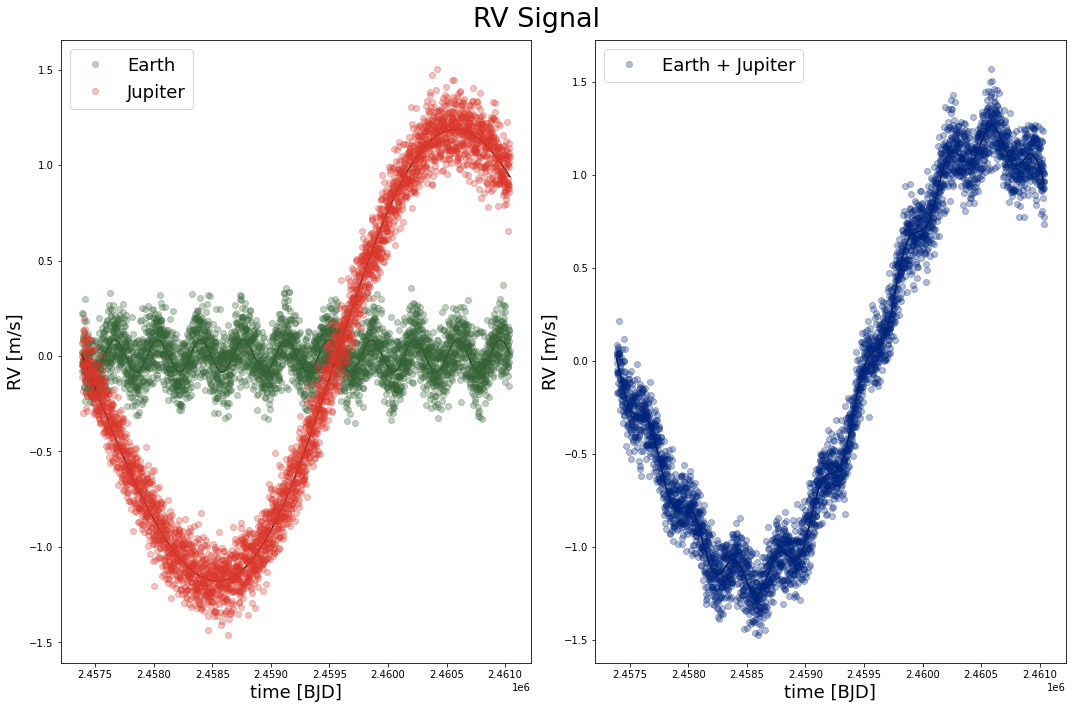

In [27]:
plot_rv_signal(
    n_planets, 
    rv_orbit, 
    rv_orbit_sum, 
    rv_sim, 
    rv_sim_sum, 
    times_rv, 
    times_observed_rv)

In [28]:
def plot_astrometry_signal(
    n_planets, 
    theta_orbit, 
    theta_orbit_sum, 
    theta_sim, 
    theta_sim_sum, 
    rho_orbit, 
    rho_orbit_sum, 
    rho_sim, 
    rho_sim_sum,
    times_astrometry,
    times_observed_astrometry):
    
    
    fig, ax = plt.subplots(2, 2, figsize = [15,10], sharex = True)
    fig.suptitle("Astrometric Signal", fontsize = 27)
    ax0 = ax[0][0]
    ax1 = ax[1][0]
    ax2 = ax[0][1]
    ax3 = ax[1][1]

    ax0.plot(times_astrometry, theta_orbit.T[0], color = 'k')
    ax0.plot(times_astrometry, theta_orbit.T[1], color = 'k')
    ax0.plot(times_observed_astrometry, theta_sim.T[0], 'o', color = '#366537', label = 'Earth', alpha = 0.3)
    ax0.plot(times_observed_astrometry, theta_sim.T[1], 'o', color = '#db372b', label = 'Jupiter', alpha = 0.3)
    ax0.set_ylabel(r"$\theta$ [radians east of north]", fontsize = 18)
    ax0.legend(fontsize = 18)

    ax1.plot(times_astrometry, rho_orbit.T[0], color = 'k')
    ax1.plot(times_astrometry, rho_orbit.T[1], color = 'k')
    ax1.plot(times_observed_astrometry, rho_sim.T[0], 'o', color = '#366537', label = 'Earth', alpha = 0.3)
    ax1.plot(times_observed_astrometry, rho_sim.T[1], 'o', color = '#db372b', label = 'Jupiter', alpha = 0.3)
    ax1.set_ylabel("separation [arcseconds]", fontsize = 18)
    ax1.set_xlabel("time [BJD]", fontsize = 18)
    ax1.legend(fontsize = 18)

    ax2.plot(times_astrometry, theta_orbit_sum, color = 'k')
    ax2.plot(times_observed_astrometry, theta_sim_sum, 'o', color = '#00257c', label = 'Earth + Jupiter', alpha = 0.3)
    ax2.set_ylabel(r"$\theta$ [radians east of north]", fontsize = 18)
    ax2.legend(fontsize = 18)

    ax3.plot(times_astrometry, rho_orbit_sum, color = 'k')
    ax3.plot(times_observed_astrometry, rho_sim_sum, 'o', color = '#00257c', label = 'Earth + Jupiter', alpha = 0.3)
    ax3.set_ylabel("separation [arcseconds]", fontsize = 18)
    ax3.set_xlabel("time [BJD]", fontsize = 18)
    ax3.legend(fontsize = 18)

    fig.tight_layout()
    fig.show()
    
    return None

/Users/Danielyahalomi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


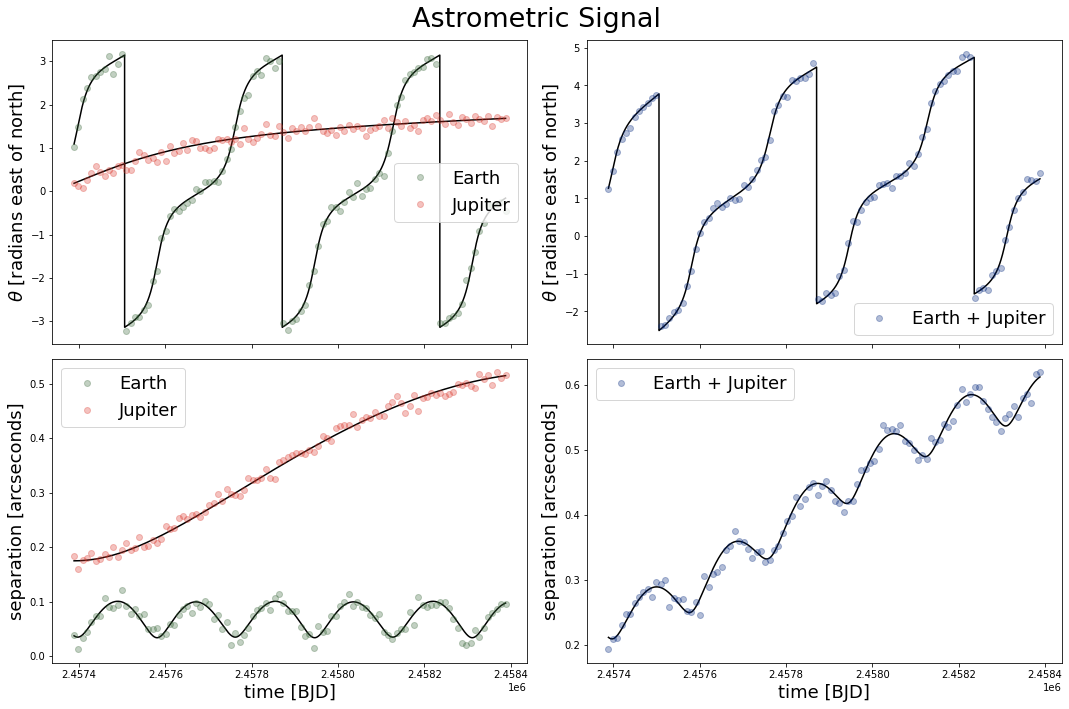

In [29]:
plot_astrometry_signal(
    n_planets, 
    theta_orbit, 
    theta_orbit_sum, 
    theta_sim, 
    theta_sim_sum, 
    rho_orbit, 
    rho_orbit_sum, 
    rho_sim, 
    rho_sim_sum,
    times_astrometry,
    times_observed_astrometry)

In [23]:
def simulate_and_plot(
    n_planets, 
    t_dur_rv, 
    n_obs_rv, 
    sigma_rv, 
    t_dur_astrometry, 
    n_obs_astrometry, 
    sigma_theta,
    sigma_rho,
    plx,
    orbit_params):
    
    
    simulate_results = simulate_data(
        n_planets, 
        t_dur_rv, 
        n_obs_rv, 
        sigma_rv, 
        t_dur_astrometry, 
        n_obs_astrometry, 
        sigma_theta,
        sigma_rho,
        plx,
        orbit_params)
    
    
    [[times_rv, times_observed_rv, times_astrometry, times_observed_astrometry],
     [rv_orbit, rv_orbit_sum, rv_sim, rv_sim_sum],
     [theta_orbit, theta_orbit_sum, theta_sim, theta_sim_sum],
     [rho_orbit, rho_orbit_sum, rho_sim, rho_sim_sum]]  = simulate_results
    
    
    plot_rv_signal(
        n_planets, 
        rv_orbit, 
        rv_orbit_sum, 
        rv_sim, 
        rv_sim_sum, 
        times_rv, 
        times_observed_rv)
        
        
    
    plot_astrometry_signal(
        n_planets, 
        theta_orbit, 
        theta_orbit_sum, 
        theta_sim, 
        theta_sim_sum, 
        rho_orbit, 
        rho_orbit_sum, 
        rho_sim, 
        rho_sim_sum,
        times_astrometry,
        times_observed_astrometry)
    
    return None

/Users/Danielyahalomi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/Danielyahalomi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


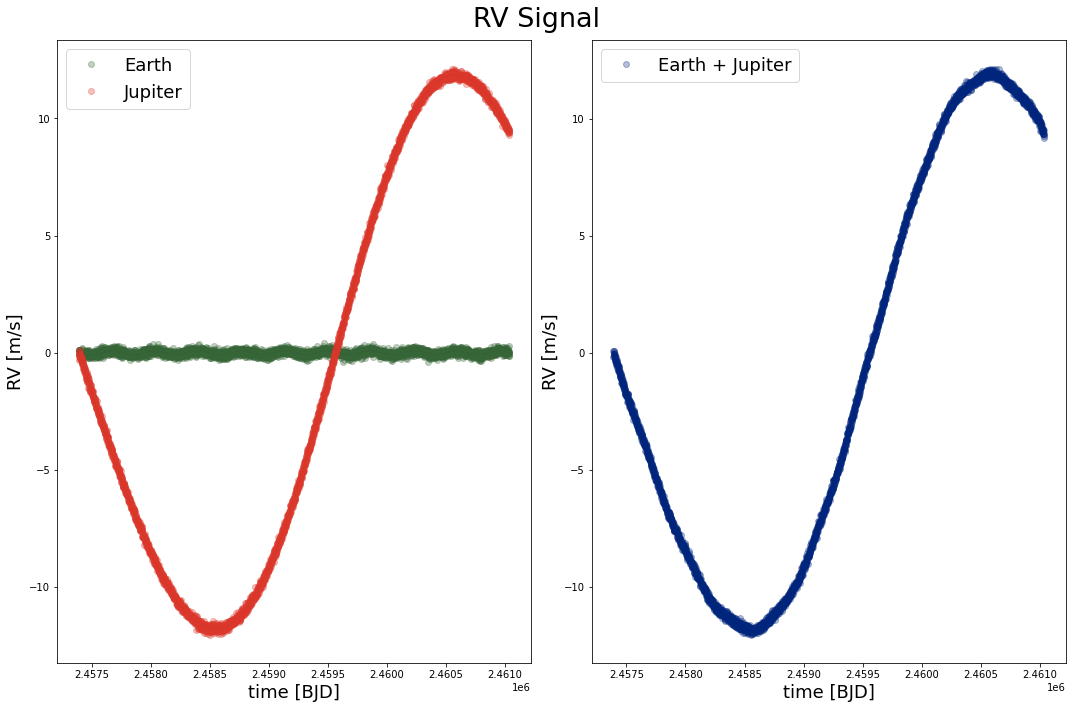

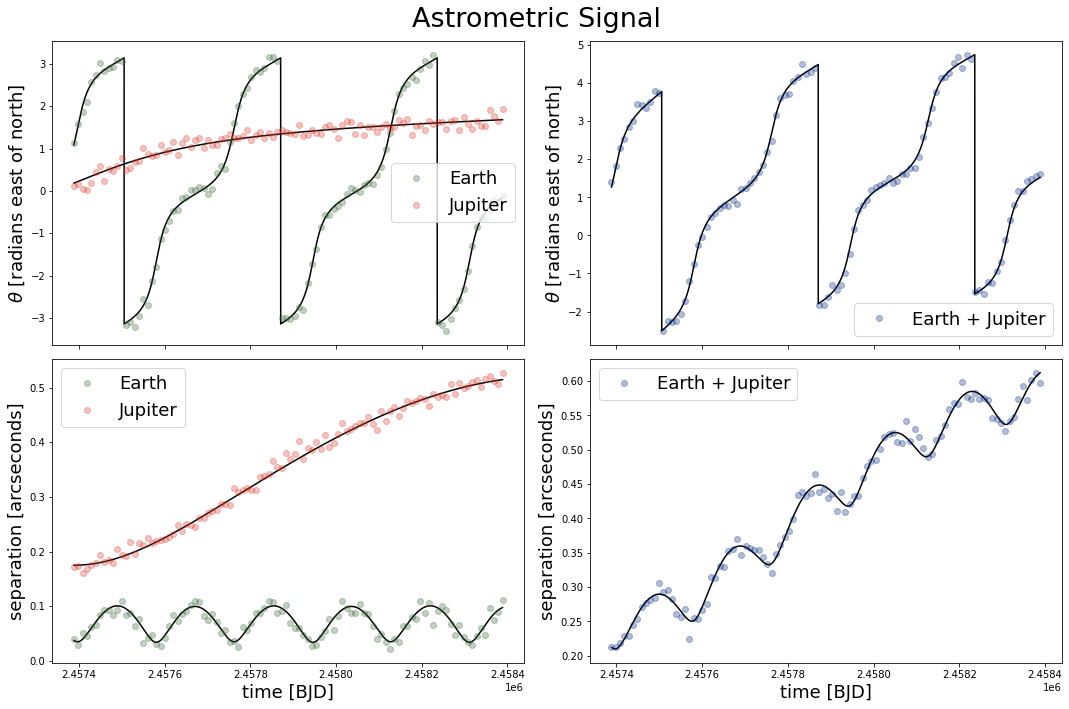

In [49]:
orbit_params_earth = [P_earth, e_earth, T0_earth, omega_earth, Omega_earth, inclination_earth, m_earth]
orbit_params_jup = [P_jup, e_jup, T0_jup, omega_jup, Omega_jup, inclination_jup, m_jup]

orbit_params_combined = [orbit_params_earth, orbit_params_jup]

n_planets = 2
t_dur_rv = 3650
n_obs_rv = 3650
sigma_rv = 0.1
t_dur_astrometry = 1000
n_obs_astrometry = 100
sigma_theta = 0.1
sigma_rho = 0.01
plx = 0.1

simulate_and_plot(
    n_planets, 
    t_dur_rv, 
    n_obs_rv, 
    sigma_rv, 
    t_dur_astrometry, 
    n_obs_astrometry, 
    sigma_theta,
    sigma_rho,
    plx,
    orbit_params_combined)

